<h1 align="center">ICAT3210 (2021) - Applied Machine Learning - Project Work</h1>


\
This notebook is a project work for the course Applied Machine Learning (2021)\
University of Vaasa (Vaasa, Finland)\

### Instroduction

This project work aims to build a network intrusion detection (NID) with Machine Learning approach by creating classification models that are trained and tested with the NSL-KDD dataset published by the Canadian Institute for Cybersecurity.
https://www.unb.ca/cic/datasets/nsl.html

#### Network Intrusion Detection (NID)

In general, an NID solution can be a device or a software program that monitors the network traffic (network packages) for identifying malicious activity (threat from externals) or policy violated activity (violation from internals). The scale of an IDS could be from small mobile devices network to large cloud computing network, almost all digitalized products that have access to a network can become targets and be vulnerable under network intrusion threat.

Conventional and well-known designs for NID solutions are signature-based detection that detects attacks by comparing the network traffic with known patterns, or reputation-based detection that recognizes the potential threat according to the reputation scores. These NIDs rely on manually pre-analysed results which are not adaptive enough to the fast growing network data. Hence, for such large scale networks and continuously-expanding data, we need a NID solution that be able to learn network traffic features to be able to detect unknow and evolving network attacks. These needs lead to Machine Learning based solutions.

#### NSL-KDD dataset

NSL-KDD is a data set for researchers to benchmark their own NID applications, and is an improved version of its precessors. Improvements of the data set ([source](https://www.unb.ca/cic/datasets/nsl.html)):
- No redundant records in the train set.
- No duplicate records in the proposed test sets.
- The number of selected records from each difficulty level group is inversely proportional to the percentage of records in the original KDD data set.
- The number of records in the train and test sets are reasonable, which makes it affordable to run the experiments on the complete set without the need to randomly select a small portion.

Description regarding the data files ([source](https://www.unb.ca/cic/datasets/nsl.html)):
- KDDTrain+.ARFF: The full NSL-KDD train set with binary labels in ARFF format
- KDDTrain+.TXT: The full NSL-KDD train set including attack-type labels and difficulty level in CSV format
- KDDTrain+_20Percent.ARFF: A 20% subset of the KDDTrain+.arff file
- KDDTrain+_20Percent.TXT: A 20% subset of the KDDTrain+.txt file
- KDDTest+.ARFF: The full NSL-KDD test set with binary labels in ARFF format
- KDDTest+.TXT: The full NSL-KDD test set including attack-type labels and difficulty level in CSV format
- KDDTest-21.ARFF: A subset of the KDDTest+.arff file which does not include records with difficulty level of 21 out of 21
- KDDTest-21.TXT: A subset of the KDDTest+.txt file which does not include records with difficulty level of 21 out of 21

### 1. Importing required dependencies
Firstly, we import common necessary libraries such as `numpy`, `matplotlib.pyplot` and `seaborn` for working with numpy array data and graph drawing libs.

We will also use below from sklearn for data preprocessing.
- `OneHotEncoder`: To encode categorical features as one-hot numeric array.
- `LabelEncoder`: To encode labels as numeric value between 0 and n_classes-1.
- `StandardScaler`: To standardize numeric features so that they have mean as 0 and std as 1.
- `PCA` and `GaussianMixture`: To perform principle component analysis and data clustering for testing purposes.
- `neighbors` and `svm.SVC`: for building classification models using K-Nearest Neighbors (k-NN) and Support Vector Machine (SVM) methods.

We will need dependencies as well from tensorflow, keras libraries for making a multilayer perceptron (MLP) densed neural network.

In [215]:
# Import libraries that will be used in this notebook.
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import joblib
from sklearn import neighbors, metrics
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.losses import sparse_categorical_crossentropy
from tensorflow.keras.optimizers import Adam

In [2]:
train_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTrain+.txt")
test_dataset_path = os.path.join("NSL_KDD_Dataset", "KDDTest+.txt")

col_names = np.array(["duration","protocol_type","service","flag","src_bytes", "dst_bytes","land",
                      "wrong_fragment","urgent","hot","num_failed_logins","logged_in","num_compromised",
                      "root_shell","su_attempted","num_root","num_file_creations","num_shells",
                      "num_access_files","num_outbound_cmds","is_host_login","is_guest_login",
                      "count","srv_count","serror_rate","srv_serror_rate","rerror_rate",
                      "srv_rerror_rate","same_srv_rate","diff_srv_rate","srv_diff_host_rate",
                      "dst_host_count","dst_host_srv_count","dst_host_same_srv_rate",
                      "dst_host_diff_srv_rate","dst_host_same_src_port_rate","dst_host_srv_diff_host_rate",
                      "dst_host_serror_rate","dst_host_srv_serror_rate","dst_host_rerror_rate",
                      "dst_host_srv_rerror_rate","labels"])

In [276]:
def read_file(path):
    # Read in the CSV file and convert "?" to NaN
    df = pd.read_csv(path, header=None, na_values="?" )
    # Drop the last column in the dataset since it's only meant for diff level
    df.drop(df.columns[len(df.columns)-1], axis=1, inplace=True)
    df.columns = col_names
    return df

def get_data():
    # This will merge the train and test data to form a full dataset
    df_train = read_file(train_dataset_path)
    df_test = read_file(test_dataset_path)
    df = pd.concat([df_train, df_test], axis = 0, ignore_index=True)
    return df

df = get_data()
print(df.info())
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 148517 entries, 0 to 148516
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     148517 non-null  int64  
 1   protocol_type                148517 non-null  object 
 2   service                      148517 non-null  object 
 3   flag                         148517 non-null  object 
 4   src_bytes                    148517 non-null  int64  
 5   dst_bytes                    148517 non-null  int64  
 6   land                         148517 non-null  int64  
 7   wrong_fragment               148517 non-null  int64  
 8   urgent                       148517 non-null  int64  
 9   hot                          148517 non-null  int64  
 10  num_failed_logins            148517 non-null  int64  
 11  logged_in                    148517 non-null  int64  
 12  num_compromised              148517 non-null  int64  
 13 

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,labels
0,0,tcp,ftp_data,SF,491,0,0,0,0,0,...,25,0.17,0.03,0.17,0.00,0.00,0.00,0.05,0.00,normal
1,0,udp,other,SF,146,0,0,0,0,0,...,1,0.00,0.60,0.88,0.00,0.00,0.00,0.00,0.00,normal
2,0,tcp,private,S0,0,0,0,0,0,0,...,26,0.10,0.05,0.00,0.00,1.00,1.00,0.00,0.00,neptune
3,0,tcp,http,SF,232,8153,0,0,0,0,...,255,1.00,0.00,0.03,0.04,0.03,0.01,0.00,0.01,normal
4,0,tcp,http,SF,199,420,0,0,0,0,...,255,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,normal


In [277]:
# Dictionary that contains mapping of multiple attacks to the four main categories
attack_dict = {
    # Normal traffic
    'normal': 'normal',
    # DoS attack
    'back': 'DoS',
    'land': 'DoS',
    'neptune': 'DoS',
    'pod': 'DoS',
    'smurf': 'DoS',
    'teardrop': 'DoS',
    'mailbomb': 'DoS',
    'apache2': 'DoS',
    'processtable': 'DoS',
    'udpstorm': 'DoS',
    # Probe
    'ipsweep': 'Probe',
    'nmap': 'Probe',
    'portsweep': 'Probe',
    'satan': 'Probe',
    'mscan': 'Probe',
    'saint': 'Probe',
    # R2L
    'ftp_write': 'R2L',
    'guess_passwd': 'R2L',
    'imap': 'R2L',
    'multihop': 'R2L',
    'phf': 'R2L',
    'spy': 'R2L',
    'warezclient': 'R2L',
    'warezmaster': 'R2L',
    'sendmail': 'R2L',
    'named': 'R2L',
    'snmpgetattack': 'R2L',
    'snmpguess': 'R2L',
    'xlock': 'R2L',
    'xsnoop': 'R2L',
    'worm': 'R2L',
    # U2R
    'buffer_overflow': 'U2R',
    'loadmodule': 'U2R',
    'perl': 'U2R',
    'rootkit': 'U2R',
    'httptunnel': 'U2R',
    'ps': 'U2R',    
    'sqlattack': 'U2R',
    'xterm': 'U2R'
}

categorical_inx = [1, 2, 3]
binary_inx = [6, 11, 13, 20, 21]
numeric_inx = list(set(range(41)).difference(categorical_inx).difference(binary_inx))

categorical_cols = col_names[categorical_inx].tolist()
binary_cols = col_names[binary_inx].tolist()
numeric_cols = col_names[numeric_inx].tolist()

def add_labels_5(df):
    # Encode and save labels (Y) into variable "labels"
    labels = df['labels'].map(lambda key: attack_dict[key])
    df['labels5'] = labels
    return df

df = add_labels_5(df)
df['labels5'].describe()

count     148517
unique         5
top       normal
freq       77054
Name: labels5, dtype: object

  labels5  counts
0     DoS   53385
1   Probe   14077
2     R2L    3749
3     U2R     252
4  normal   77054
[53385 14077  3749   252 77054]


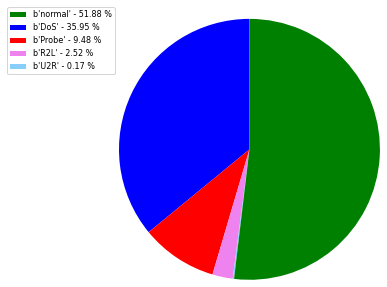

In [278]:
labels5 = ['normal', 'DoS', 'Probe', 'R2L', 'U2R']
# Labels columns 
summary_attack = df.groupby(['labels5']).size().reset_index(name='counts')
print(summary_attack)


x = np.char.array(summary_attack['labels5'])
y = np.array(summary_attack['counts'])
print(y)
colors = ['blue','red','violet','lightskyblue','green']
porcent = 100.*y/y.sum()

patches, texts = plt.pie(y, colors=colors, startangle=90, radius=1.5)
labels = ['{0} - {1:1.2f} %'.format(i,j) for i,j in zip(x, porcent)]

sort_legend = True
if sort_legend:
    patches, labels, dummy =  zip(*sorted(zip(patches, labels, y),
                                          key=lambda x: x[2],
                                          reverse=True))

plt.legend(patches, labels, loc='center right', bbox_to_anchor=(-0.1, 1.),
           fontsize=8)


In [279]:
# Categorical columns
(df[categorical_cols].describe().transpose())

,count,unique,top,freq
protocol_type,148517,3,tcp,121569
service,148517,70,http,48191
flag,148517,11,SF,89820


In [280]:
# Binary columns
(df[binary_cols].describe().transpose())

,count,mean,std,min,25%,50%,75%,max
land,148517.0,0.000215,0.014677,0.0,0.0,0.0,0.0,1.0
logged_in,148517.0,0.402789,0.490461,0.0,0.0,0.0,1.0,1.0
root_shell,148517.0,0.001508,0.038807,0.0,0.0,0.0,0.0,1.0
is_host_login,148517.0,0.000081,0.008988,0.0,0.0,0.0,0.0,1.0
is_guest_login,148517.0,0.012308,0.110259,0.0,0.0,0.0,0.0,1.0


In [281]:
# Numeric columns
print(len(numeric_cols))
df[numeric_cols].describe().transpose()

33


,count,mean,std,min,25%,50%,75%,max
duration,148517.0,276.779305,2.460683e+03,0.0,0.00,0.00,0.00,5.771500e+04
src_bytes,148517.0,40227.949299,5.409612e+06,0.0,0.00,44.00,278.00,1.379964e+09
dst_bytes,148517.0,17088.853593,3.703525e+06,0.0,0.00,0.00,571.00,1.309937e+09
wrong_fragment,148517.0,0.020523,2.400691e-01,0.0,0.00,0.00,0.00,3.000000e+00
urgent,148517.0,0.000202,1.941708e-02,0.0,0.00,0.00,0.00,3.000000e+00
hot,148517.0,0.189379,2.013160e+00,0.0,0.00,0.00,0.00,1.010000e+02
num_failed_logins,148517.0,0.004323,7.224823e-02,0.0,0.00,0.00,0.00,5.000000e+00
num_compromised,148517.0,0.255062,2.223137e+01,0.0,0.00,0.00,0.00,7.479000e+03
su_attempted,148517.0,0.000976,4.238907e-02,0.0,0.00,0.00,0.00,2.000000e+00
num_root,148517.0,0.273726,2.268902e+01,0.0,0.00,0.00,0.00,7.468000e+03


In [282]:
def drop_useless_column(df):
  # Drop column "num_outbound_cmds" since its value is always 0.
  del df['num_outbound_cmds']
  return df

drop_useless_column(df)
numeric_cols.remove('num_outbound_cmds')

In [283]:
# Some functions needed for visualizing in descending order correlation value.
def get_redundant_pairs(in_df):
    # Get only the diagonal and lower triangular pairs of correlation matrix
    redundant_pairs = set()
    cols = in_df.columns
    for i in range(0, in_df.shape[1]):
        for j in range(0, i+1):
            redundant_pairs.add((cols[i], cols[j]))
    return redundant_pairs

def get_top_abs_correlations(in_df, n=5):
    top_corrs = in_df.corr().abs().unstack()
    drop_labels = get_redundant_pairs(in_df)
    top_corrs = top_corrs.drop(labels=drop_labels).sort_values(ascending=False)
    return top_corrs[0:n]

# Data preprocessing

## One Hot Encoding for categorical features

We have in the dataset categorical variables which are stored as text values. We need to change these variables into numerical values for further processing since there are many ML algorithms which can not support categorical variables.
There are many methods to encode categorical data:
1. label encoding (convert each value to a number)
2. one-hot encoding (transfer categories into separated columns which have value either 0 or 1)
3. custom binary encoding (a combination of label and one-hot encoding).

Label encoding has the advantage that it is simple and quite straightforward, but the numerical values can be misleading to the algorithms. For instance, the category which is encoded to 4 does not necessarily have more weight than those have value of 0, 1, 2 or 3.
A recommended alternative approach is to use one-hot encoding. Generally speaking, one-hot encoding converts each category value into a new column and assigns either 1 or 0 value to the column.

## Standardization for numerical features

Perform feature scaling for PCA

Standardization is the process of scaling data so that they have a mean value of 0 and a standard deviation of 1.

It's more useful and common for classification tasks.
   
   $ X' = \frac{X - \mu}\sigma $
   
with $\mu$ is mean value and $\sigma$ is standard deviation.

Number of components: 3, explained variance ratio: 0.4241499762968983
Number of components: 4, explained variance ratio: 0.47991213626612594
Number of components: 5, explained variance ratio: 0.5309135185305831
Number of components: 6, explained variance ratio: 0.5709100632247445
Number of components: 7, explained variance ratio: 0.6053103574578401
Number of components: 8, explained variance ratio: 0.637606783394264
Number of components: 9, explained variance ratio: 0.6683980283993702
Number of components: 10, explained variance ratio: 0.6987909074288783
Number of components: 11, explained variance ratio: 0.7285989980675128
Number of components: 12, explained variance ratio: 0.758034619760439
Number of components: 13, explained variance ratio: 0.7874079213489719
Number of components: 14, explained variance ratio: 0.8157388965243394
Number of components: 15, explained variance ratio: 0.8436336091917163
Number of components: 16, explained variance ratio: 0.8697906799566524
Number of comp

Text(0, 0.5, 'variance %')

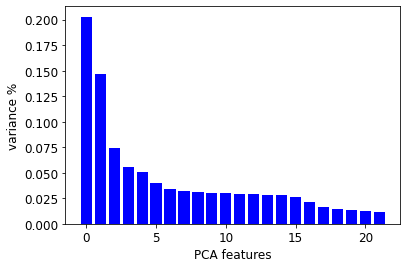

In [285]:
one_hot_encoder = OneHotEncoder(sparse=False)
one_hot_encoder.fit(df[categorical_cols])

scaler = StandardScaler()
scaler.fit(df[numeric_cols])

def apply_one_hot_encoder(df):
    # Transfer quantitative (categorical) data to qualitative (numeric) data using OneHotEncoder
    transformed = one_hot_encoder.transform(df[categorical_cols])
    processed_df = pd.DataFrame(transformed, columns=one_hot_encoder.get_feature_names_out())
    processed_df[binary_cols] = df[binary_cols]
    # Apply standard scaling to numerical data before feeding data to PCA
    processed_df[numeric_cols] = scaler.transform(df[numeric_cols])
    return processed_df

processed_df = apply_one_hot_encoder(df)

# Loop function to identify number of principal components that explain at least 90% of the variance
for k in range(3, processed_df.shape[1]):
    pca = PCA(n_components= k, random_state=12)
    pca.fit(processed_df)
    k_ratio = pca.explained_variance_ratio_.sum()
    final_k = k
    print(f'Number of components: {k}, explained variance ratio: {k_ratio}')
    if k_ratio > 0.95:
        break

Final_PCA = PCA(n_components=final_k, random_state=12)
Final_PCA.fit(processed_df)

def apply_pca(processed_df):
    return Final_PCA.transform(processed_df)

projected_df = apply_pca(processed_df)

# Plot the explained variances
features = range(Final_PCA.n_components_)
plt.bar(features, Final_PCA.explained_variance_ratio_, color='blue')
plt.xlabel('PCA features')
plt.ylabel('variance %')

In [ ]:
X = projected_df
# Fit the model
gmm = GaussianMixture(n_components=5, random_state = 1)
gmm.fit(X)
# Predict clusters
y_gmm = gmm.predict(X)
centers_gmm = gmm.means_
# Plot the data
plt.scatter(X[:, 0], X[:, 1], c=y_gmm, s=15, cmap='rainbow')
plt.colorbar()
plt.scatter(centers_gmm[:, 0], centers_gmm[:, 1], c='black', s=100, alpha=0.8, marker='x');
plt.title('GMM Predictions using PCA projection')
plt.xlabel('PC1')
plt.ylabel('PC2')


In [306]:
le = LabelEncoder()
le.fit(df['labels5'])

def preprocess(enable_pca:bool = False):
    df = drop_useless_column(add_labels_5(get_data()))
    y = LabelEncoder().fit_transform(df['labels5'])
    if enable_pca:
        x = apply_pca(apply_one_hot_encoder(df))
    else:
        x = apply_one_hot_encoder(df).to_numpy()
    return x, y, df['labels5']

def prepare_input_data(enable_pca:bool = False):
    X, y, labeled_df = preprocess(enable_pca)
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
    label_mapping = dict(zip(le.transform(le.classes_), le.classes_))
    print(label_mapping)
    print(X_train.shape)
    return X_train, X_test, y_train, y_test

In [307]:
def show_confusion_matrix(cm):
    ax= plt.subplot()
    sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix of the Classifier')
    ax.xaxis.set_ticklabels(le.classes_)
    ax.yaxis.set_ticklabels(le.classes_)

def show_report_roc(model, x_test, y_test):
    yh_test = model.predict(x_test)
    yh_prob = model.predict_proba(x_test)
    
    print(classification_report(y_test, yh_test, target_names=le.classes_))
    fig, ax = plt.subplots(figsize=(10, 8))
    skplt.metrics.plot_roc(y_test, yh_prob, ax=ax)
    plt.show()

def model_name(k):
    return 'model_' + str(k) + '.h5'

In [308]:
training = True

{0: 'DoS', 1: 'Probe', 2: 'R2L', 3: 'U2R', 4: 'normal'}
(111387, 121)
Epoch 1/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.1185 - sparse_categorical_accuracy: 0.9633A: 1s - loss: 0.1852 - sparse_categorical_accuracy: 0 - ETA: 0s - loss: 0.1601 - sparse_categorical_a - ETA: 0s - loss: 0.1194 - sparse_categorical_accuracy: 0.962

Epoch 00001: sparse_categorical_accuracy improved from -inf to 0.96328, saving model to ./ANN_KFold_Models0\model_1.h5
Epoch 2/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.0506 - sparse_categorical_accuracy: 0.9840

Epoch 00002: sparse_categorical_accuracy improved from 0.96328 to 0.98400, saving model to ./ANN_KFold_Models0\model_1.h5
Epoch 3/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.0423 - sparse_categorical_accuracy: 0.9858A: 1s - loss: 0.0490 - 

Epoch 00003: sparse_categorical_accuracy improved from 0.98400 to 0.98577, saving model to ./ANN_KFold_Models0\model_1.h5
Epoch 4/15
1783

1783/1783 [==============================] - 3s 1ms/step - loss: 0.0399 - sparse_categorical_accuracy: 0.9861

Epoch 00003: sparse_categorical_accuracy improved from 0.98435 to 0.98610, saving model to ./ANN_KFold_Models0\model_3.h5
Epoch 4/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.0358 - sparse_categorical_accuracy: 0.9873

Epoch 00004: sparse_categorical_accuracy improved from 0.98610 to 0.98731, saving model to ./ANN_KFold_Models0\model_3.h5
Epoch 5/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.0339 - sparse_categorical_accuracy: 0.9881A: 1s - loss: 0.0332 - spars

Epoch 00005: sparse_categorical_accuracy improved from 0.98731 to 0.98810, saving model to ./ANN_KFold_Models0\model_3.h5
Epoch 6/15
1783/1783 [==============================] - 3s 1ms/step - loss: 0.0318 - sparse_categorical_accuracy: 0.9886

Epoch 00006: sparse_categorical_accuracy improved from 0.98810 to 0.98861, saving model to ./ANN_KFold_Models0\model_3.h5
Epoch 7

Epoch 6/15
1783/1783 [==============================] - 3s 2ms/step - loss: 0.0311 - sparse_categorical_accuracy: 0.9893A:

Epoch 00006: sparse_categorical_accuracy improved from 0.98833 to 0.98926, saving model to ./ANN_KFold_Models0\model_5.h5
Epoch 7/15
1783/1783 [==============================] - 3s 1ms/step - loss: 0.0300 - sparse_categorical_accuracy: 0.9894A: 1s - loss: 0.0293 - sparse_cat

Epoch 00007: sparse_categorical_accuracy improved from 0.98926 to 0.98941, saving model to ./ANN_KFold_Models0\model_5.h5
Epoch 8/15
1783/1783 [==============================] - 3s 2ms/step - loss: 0.0286 - sparse_categorical_accuracy: 0.9899

Epoch 00008: sparse_categorical_accuracy improved from 0.98941 to 0.98992, saving model to ./ANN_KFold_Models0\model_5.h5
Epoch 9/15
1783/1783 [==============================] - 2s 1ms/step - loss: 0.0273 - sparse_categorical_accuracy: 0.9902

Epoch 00009: sparse_categorical_accuracy improved from 0.98992 to 0.99021, saving model to ./ANN_KFold_Models0\

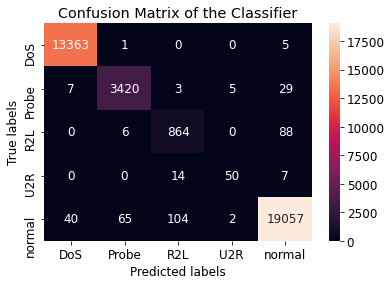

In [310]:
%%time

save_dir = './ANN_KFold_Models0/'
X_train, X_test, y_train, y_test = prepare_input_data(True)

# Model configuration
batch_size = 50
loss_function = sparse_categorical_crossentropy
no_epochs = 15
optimizer = Adam()
verbosity = 1
num_folds = 5

# Define the K-fold Cross Validator
kfold = KFold(n_splits=num_folds, shuffle=True)
# Define Kfolds score containers
acc_per_fold = []
loss_per_fold = []
scores = []
max_val_accuracy = 0
best_model = None

# K-fold Cross Validation
fold_no = 1
for train, test in kfold.split(X_train, y_train):

    # Define checkpoint for getting best models
    checkpoint = tf.keras.callbacks.ModelCheckpoint(save_dir + model_name(fold_no), 
                                                    monitor='sparse_categorical_accuracy', verbose=1, 
                                                    save_best_only=True, mode='max')
    # Tunable parameters number = (121*64 + 64) + (64*32 + 32) + (32*5 + 5) = 12,293
    # Define model architecture
    ann_model = keras.Sequential([
        # hidden layers
        layers.Dense(64, activation='relu', input_shape=(X_train.shape[1],)),
        layers.Dense(32, activation='relu'),
        # output layer
        layers.Dense(5, activation='softmax')
    ])

    # Compile the model
    ann_model.compile(optimizer=optimizer,
                  loss=loss_function,
                  metrics=['sparse_categorical_accuracy'])

    # Fit data to model
    history = ann_model.fit(X_train[train], y_train[train],
                            batch_size=batch_size,
                            epochs=no_epochs,
                            callbacks=[checkpoint],
                            verbose=verbosity)

    # Load the best model to evaluate the performance of the model
    ann_model.load_weights(save_dir + model_name(fold_no))

    # Generate generalization metrics
    score = ann_model.evaluate(X_train[test], y_train[test], verbose=0)
    print(f'>>> Score for fold {fold_no}: {ann_model.metrics_names[0]} = {score[0]}; {ann_model.metrics_names[1]} = {score[1]}')
    acc_per_fold.append(score[1])
    loss_per_fold.append(score[0])
    scores.append(score)

    if score[1] > max_val_accuracy:
        max_val_accuracy = score[1]
        best_model = ann_model

    # Increase fold number
    fold_no += 1

# Show average scores
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print(f'>>> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}')
print('Average scores for all folds:')
print(f'Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'Average of Loss: {np.mean(loss_per_fold)}')
print(f'Maximum validation accuracy: {max_val_accuracy}')
best_model.save('ANN_KFold.h5', overwrite=True)

print(best_model.evaluate(X_test,  y_test, verbose=2))
ann_yhat_test = best_model.predict(X_test)
ann_cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=ann_yhat_test.argmax(axis=1))
show_confusion_matrix(ann_cm_test)

# Summary the models layers and trainable params
best_model.summary()

In [301]:
for train, test in kfold.split(X_train, y_train):

    print(X_train[train].shape)
    print(X_train[test].shape)

(89109, 22)
(22278, 22)
(89109, 22)
(22278, 22)
(89110, 22)
(22277, 22)
(89110, 22)
(22277, 22)
(89110, 22)
(22277, 22)


In [319]:
# Summary the models layers and trainable params
from keras.utils.vis_utils import plot_model
plot_model(best_model, to_file='ann_model_plot.png', show_shapes=True, show_layer_names=True)
print(classification_report(y_test, ann_yhat_test.argmax(axis=1), target_names=le.classes_))

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     13369
       Probe       0.98      0.99      0.98      3464
         R2L       0.88      0.90      0.89       958
         U2R       0.88      0.70      0.78        71
      normal       0.99      0.99      0.99     19268

    accuracy                           0.99     37130
   macro avg       0.94      0.92      0.93     37130
weighted avg       0.99      0.99      0.99     37130



Training accuracy score: 0.9934552506127285
Testing accuracy score: 0.9909776461082682
Cross validation score with testing data: 0.9867492593590089
Confusion matrix of KNN testing:

Wall time: 9min 19s


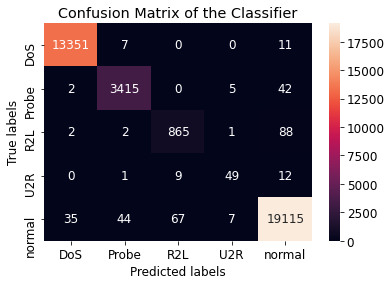

In [312]:
%%time

n_neighbors = 5
knn_classifier = neighbors.KNeighborsClassifier(n_neighbors)

if training:
    knn_classifier.fit(X_train, y_train)
    joblib.dump(knn_classifier, 'knn_model')
else:
    knn_classifier = joblib.load('knn_model')
    
knn_yh_train = knn_classifier.predict(X_train)
knn_yh_test = knn_classifier.predict(X_test)

knn_cm_train = metrics.confusion_matrix(y_true=y_train, y_pred=knn_yh_train)
knn_cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=knn_yh_test)
knn_acc_train = metrics.accuracy_score(y_true=y_train, y_pred=knn_yh_train)
knn_acc_test = metrics.accuracy_score(y_true=y_test, y_pred=knn_yh_test)

print(f'Training accuracy score: {knn_acc_train}')
print(f'Testing accuracy score: {knn_acc_test}')

knn_cv_score = cross_val_score(knn_classifier, X_test, y_test, cv=5).mean()
print(f'Cross validation score with testing data: {knn_cv_score}')

print('Confusion matrix of KNN testing:\n')
show_confusion_matrix(knn_cm_test)

              precision    recall  f1-score   support

         DoS       1.00      1.00      1.00     13369
       Probe       0.98      0.99      0.99      3464
         R2L       0.92      0.90      0.91       958
         U2R       0.79      0.69      0.74        71
      normal       0.99      0.99      0.99     19268

    accuracy                           0.99     37130
   macro avg       0.94      0.91      0.92     37130
weighted avg       0.99      0.99      0.99     37130



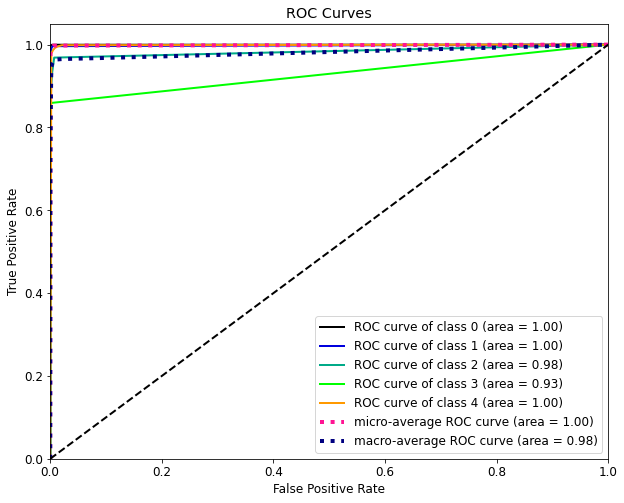

Wall time: 4min 5s


In [313]:
%%time
show_report_roc(knn_classifier, X_test, y_test)

Training accuracy score: 0.9831219083016869
Testing accuracy score: 0.9812550498249394
Cross validation score with testing data: 0.9757339078911931
Confusion matrix of KNN testing:

Wall time: 51min 48s


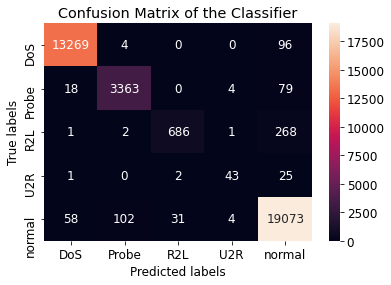

In [314]:
%%time

svc_classifier = SVC(kernel='poly', degree=3, probability=True)

if training:
    svc_classifier.fit(X_train, y_train)
    joblib.dump(svc_classifier, 'svc_model.h5')
else:
    svc_classifier = joblib.load('svc_model.h5')
    
svc_yh_train = svc_classifier.predict(X_train)
svc_yh_test = svc_classifier.predict(X_test)

svc_cm_train = metrics.confusion_matrix(y_true=y_train, y_pred=svc_yh_train)
svc_cm_test = metrics.confusion_matrix(y_true=y_test, y_pred=svc_yh_test)
svc_acc_train = metrics.accuracy_score(y_true=y_train, y_pred=svc_yh_train)
svc_acc_test = metrics.accuracy_score(y_true=y_test, y_pred=svc_yh_test)

print(f'Training accuracy score: {svc_acc_train}')
print(f'Testing accuracy score: {svc_acc_test}')

svc_cv_score = cross_val_score(svc_classifier, X_test, y_test, cv=5).mean()
print(f'Cross validation score with testing data: {svc_cv_score}')

print('Confusion matrix of SVM testing:\n')
show_confusion_matrix(svc_cm_test)

In [318]:
print(f'Training accuracy score: {svc_acc_train}')
print(f'Testing accuracy score: {svc_acc_test}')
print(f'Cross validation score with testing data: {svc_cv_score}')

print('Confusion matrix of SVM testing:\n')

Training accuracy score: 0.9831219083016869
Testing accuracy score: 0.9812550498249394
Cross validation score with testing data: 0.9757339078911931
Confusion matrix of SVM testing:



              precision    recall  f1-score   support

         DoS       0.99      0.99      0.99     13369
       Probe       0.97      0.97      0.97      3464
         R2L       0.95      0.72      0.82       958
         U2R       0.83      0.61      0.70        71
      normal       0.98      0.99      0.98     19268

    accuracy                           0.98     37130
   macro avg       0.94      0.85      0.89     37130
weighted avg       0.98      0.98      0.98     37130



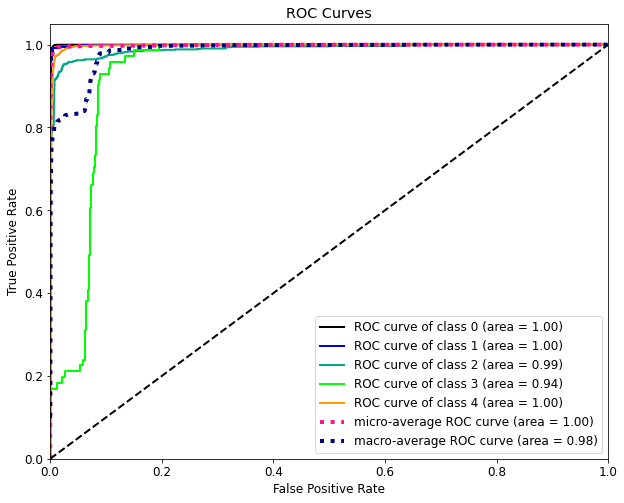

Wall time: 1min 24s


In [317]:
%%time
show_report_roc(svc_classifier, X_test, y_test)